# Download data


In [0]:
# If one doesn't have biopython installed, it can be uploaded by following command
!pip3 install biopython

     |████████████████████████████████| 2.3MB 33.5MB/s 


In [0]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import csv
import random
from scipy import sparse
import gc
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

amount of segments : 55263
amount of segments with length <= 300: 0.9912599750285
median : 135.0


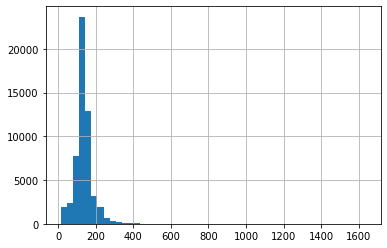

In [0]:
intervals = pd.read_csv('data/GSM3003542_Drosophila_all_w15_th-1_plus.hits.max.PDS.w50.35.bed', sep='\t', comment='t', header=None)
intervals_strand2 = pd.read_csv('data/GSM3003542_Drosophila_all_w15_th-1_minus.hits.max.PDS.w50.35.bed.gz', sep='\t', comment='t', header=None)
intervals = pd.concat([intervals,intervals_strand2], ignore_index=True)

# Define dataframe from given data
intervals.columns = ['Chr', 'Begin', 'End', 'mm']
intervals['length'] = intervals['End'] - intervals['Begin']
intervals['prob'] = intervals['mm'] / 100

chrome_names = list(intervals['Chr'].unique())

print("amount of segments :", len(intervals))
print("part of segments with length <= 300:", len(intervals[intervals['length'] <= 300]) / len(intervals['length']))
print("median :", np.median(intervals['length']))
hist = intervals['length'].hist(bins=50)

In [0]:
# Uploads 
records = list(SeqIO.parse("data/dm6.fa", "fasta"))
gene_np = {}
for record in records:
  if record.name in chrome_names:
    gene_np[record.name] = np.array(record.seq)

#Cut segments


In [0]:
gene_targets = {}
seg_size = 1000
data_target = pd.DataFrame()
data_feat = pd.DataFrame()

In [0]:
# Defines and returns target for model training 
def Create_target(name):
  chrome = gene_np[name]
  intervals_chrom = intervals[intervals['Chr'] == name]
  target = np.zeros(len(chrome))
  for i, row in intervals_chrom.iterrows():
    if (target[row.Begin : row.End].all() == 0):
      target[row.Begin : row.End] = row.prob
  return target

# Cuts array for samples for training
def CropBySegSize(target):
  target = target[:(-(len(target) % seg_size))]
  return np.array_split(target, len(target) / seg_size)
  
# Appends data array to dataframe
def AppendToDf(dataframe, data):
  df = pd.DataFrame(data)
  dataframe = dataframe.append(df, ignore_index=True)
  return dataframe

# Defines all data for trainig model
for name in chrome_names:
  target = Create_target(name)
  target = CropBySegSize(target)
  target = np.array(target)

  gene = gene_np[name]
  gene = np.array(list(map(lambda x:x.lower(), gene)))
  gene = CropBySegSize(gene)
  gene = np.array(gene)

  data_target = AppendToDf(data_target, target, name)
  data_feat = AppendToDf(data_feat, gene, name)

In [0]:
# Free some space
intervals = []
records = []
record = []
target = []
gene = []
gc.collect()

0

# Split on folds and save data

In [0]:
# Create indexes for splitting on folds
indexes = np.arange(len(data_target))
np.random.shuffle(indexes)
folds_indexes = np.split(indexes, 5) 

In [0]:
# Save some data that is needed for annotation
with open('chrome_names.npy', 'wb') as f:
  np.save(f, np.array(chrome_names))

with open('folds_indexes.npy', 'wb') as f:
  np.save(f, np.array(folds_indexes))

In [0]:
# Saves target
for i in range(5):
  path = "folds/folds_target_{i}.npz".format(i=i)
  sparse.save_npz(path, sparse.csr.csr_matrix(data_target.values[folds_indexes[i]], dtype=np.float64))

In [0]:
# Saves features
enc = OneHotEncoder(categories = [np.array(['a', 'c', 'g', 'n', 't'], dtype=object)] * 1000, sparse=True)
for i in range(5):
  fold_feat = enc.fit_transform(data_feat.values[folds_indexes[i]])
  path = "folds/folds_feat_{i}.npz".format(i=i)
  sparse.save_npz(path, fold_feat)